# Scalability
This notebook show the scalability analysis performed in the paper.
We compared our LTGL model with respect to state-of-the art software for graphical inference, such as LVGLASSO and TVGL.

<font color='red'><b>Note</b></font>: GL is not included in the comparison, since it is based on coordinate descent and it does not have the eigenvalue decomposition.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import matlab
import matlab.engine
import pandas as pd
import numpy as np
import cPickle as pkl
import time

from itertools import product

from regain import datasets, utils
from regain.admm import latent_time_graph_lasso_

ImportError: cannot import name soft_thresholding_sign

In [77]:
def ltgl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
        bypass_transpose=False, assume_centered=0, verbose=0, tol=1e-4, rtol=1e-4,
        max_iter=500, rho=1./ np.sqrt(data_grid.shape[0]))
    
    tic = time.time()
    ll = mdl.set_params(**params).fit(data_grid)
    tac = time.time()
    iterations = ll.n_iter_
    ss = utils.structure_error(K, ll.precision_)#, thresholding=1, eps=1e-5)
    MSE_observed = utils.error_norm(K_obs, ll.precision_ - ll.latent_)
    MSE_precision = utils.error_norm(K, ll.precision_)
    MSE_latent = utils.error_norm(ells, ll.latent_)
    mean_rank_error = utils.error_rank(ells, ll.latent_)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=ll)
    
    res = dict(res, **ss)
    return res

import sys; sys.path.append("/home/fede/src/TVGL")
from TVGL import TVGL
from regain import utils; reload(utils)
from regain.utils import suppress_stdout

def hallac_results(data_grid, K, K_obs, ells, beta, alpha):
    
    with suppress_stdout():
        tic = time.time()
        thetaSet, empCovSet, status, gvx = TVGL(
            np.vstack(data_grid.transpose(2,0,1)), data_grid.shape[0], lamb=alpha, beta=beta,
            indexOfPenalty=2)
        tac = time.time()

    if status != "Optimal":
        print ("not converged")
    precisions = np.array(thetaSet)
    ss = utils.structure_error(K, precisions)
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None

    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=gvx.n_iter_,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=status,
               estimator=gvx)
    
    res = dict(res, **ss)
    return res

In [3]:
try:
    eng.quit()
except:
    pass
eng = matlab.engine.start_matlab()
eng.addpath(r'/home/fede/src/slipguru/regain/regain/wrapper/lvglasso/',nargout=0)
# eng.addpath(r'path/to/ADMM_B.m/',nargout=0)

In [24]:
def chandresekeran_results(data_grid, K, K_obs, ells, tau, alpha, **whatever):
   
    emp_list = np.array([empirical_covariance(x, assume_centered=True)
                        for x in data_grid.transpose(2,0,1)]).transpose(1,2,0)
    
    n_samples = emp_list.shape[0]
    rho = 1./ np.sqrt(data_grid.shape[0])

    # 3. Matlab engine
    result = eng.LVGLASSO(matlab.double(emp_list.tolist()),float(alpha),float(tau),float(rho))
    ma_output = Bunch(**result)

    ma_output.R = np.array(ma_output.R)
    ma_output.S = np.array(ma_output.S)
    ma_output.L = np.array(ma_output.L)
    
    ss = utils.structure_error(K, ma_output.R + ma_output.L)#, thresholding=1, eps=1e-5)
    MSE_observed = utils.error_norm(K_obs, ma_output.R)
    MSE_precision = utils.error_norm(K, ma_output.R + ma_output.L)
    MSE_latent = utils.error_norm(ells, ma_output.L)
    mean_rank_error = utils.error_rank(ells, ma_output.L)
    
    res = dict(n_dim_obs=K.shape[1],
               time=ma_output.elapsed_time,
               iterations=np.max(ma_output.iter),
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None, estimator=ma_output)
 
    res = dict(res, **ss)
    return res

In [5]:
# prepare data
n_times = [20, 50, 100]
n_dims = np.sqrt(np.logspace(2,5,10)).astype(int)

n_samples = 200
n_dim_lat = 2

np.random.seed(42)
with suppress_stdout():
    data = {(dim,T) : datasets.generate_dataset(
        mode='ma', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-2)
        for dim, T in (product(n_dims, n_times))}

In [26]:
alpha = 1
tau = 1
beta = 1
eta = 1

methods = ['LTGL', 'GL', 'LVGLASSO', 'TVGL']
scores = sorted(['iterations', 'time', 'note'])

cols = pd.MultiIndex.from_product([scores, n_dims], names=('score','dim'))
rows = pd.MultiIndex.from_product([methods, n_times], names=('method','time'))

dff = pd.DataFrame(columns=cols, index=rows)
idx = pd.IndexSlice

In [78]:
for i, (k, res) in enumerate(sorted(data.items())):
    dim = k[0]
    print("Start with: dim=%d, T=%d (it %d)" % (k[0],k[1], i))
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search

    print("starting LTGL ...\r", end='')
    res_l = ltgl_results(data_grid, K, K_obs, ells, alpha=alpha, beta=beta, tau=tau, eta=eta)
    dff.loc[idx['LTGL', k[1]], idx[:, k[0]]] = [res_l[x] for x in scores]

    print("starting GL...\r", end='')
    res = glasso_results(data_grid, K, K_obs, ells, alpha=alpha)
        
    # Use this for the R-implementation 
    # res = friedman_results(data_grid, K, K_obs, ells, alpha=alpha)
    dff.loc[idx['GL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    
    print("starting LVGLASSO...\r", end='')
    res_c = chandresekeran_results(data_grid, K, K_obs, ells, tau=tau, alpha=alpha)
    dff.loc[idx['LVGLASSO', k[1]], idx[:, k[0]]] = [res_c[x] for x in scores]

Start with: dim=10, T=20 (it 0)
Start with: dim=10, T=50 (it 1)
Start with: dim=10, T=100 (it 2)
Start with: dim=14, T=20 (it 3)
Start with: dim=14, T=50 (it 4)
Start with: dim=14, T=100 (it 5)
Start with: dim=21, T=20 (it 6)
Start with: dim=21, T=50 (it 7)
Start with: dim=21, T=100 (it 8)
Start with: dim=31, T=20 (it 9)
Start with: dim=31, T=50 (it 10)
Start with: dim=31, T=100 (it 11)
Start with: dim=46, T=20 (it 12)
Start with: dim=46, T=50 (it 13)
Start with: dim=46, T=100 (it 14)
Start with: dim=68, T=20 (it 15)
Start with: dim=68, T=50 (it 16)
Start with: dim=68, T=100 (it 17)
Start with: dim=100, T=20 (it 18)
Start with: dim=100, T=50 (it 19)
Start with: dim=100, T=100 (it 20)
Start with: dim=146, T=20 (it 21)
Start with: dim=146, T=50 (it 22)
Start with: dim=146, T=100 (it 23)
Start with: dim=215, T=20 (it 24)
Start with: dim=215, T=50 (it 25)
Start with: dim=215, T=100 (it 26)
Start with: dim=316, T=20 (it 27)
Start with: dim=316, T=50 (it 28)
Start with: dim=316, T=100 (it 29

In [82]:
df.to_pickle("scalability_no_hallac.pkl")

In [101]:
logger = init_logger('scalability')

Since this is computationally expensive, we divide the results in two cells ...

In [ ]:
for i, (k, res) in enumerate(sorted(data.items())):
    dim = k[0]
    logging.info("Start TVGL with: dim=%d, T=%d (it %d)" % (k[0],k[1], i))
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search
    
    try:
#         print("starting TVGL...\r", end='')
        res = hallac_results(data_grid, K, K_obs, ells, beta=beta, alpha=alpha)
        dff.loc[idx['TVGL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
        dff.to_pickle("scalability_hallac.pkl")
    except:
        pass

INFO (2018-02-01 22:15:18,256): Start TVGL with: dim=10, T=20 (it 0)


## Plotting

In [41]:
# load pickle
with open("scalability.pkl", 'rb') as f:
    df = pkl.load(f)

df.sortlevel(inplace=True)

idx = pd.IndexSlice
scores = df.columns.levels[0]
n_dims = df.columns.levels[1]
methods = df.index.levels[0]
n_times = df.index.levels[1]

Let's plot a horizontal figure.

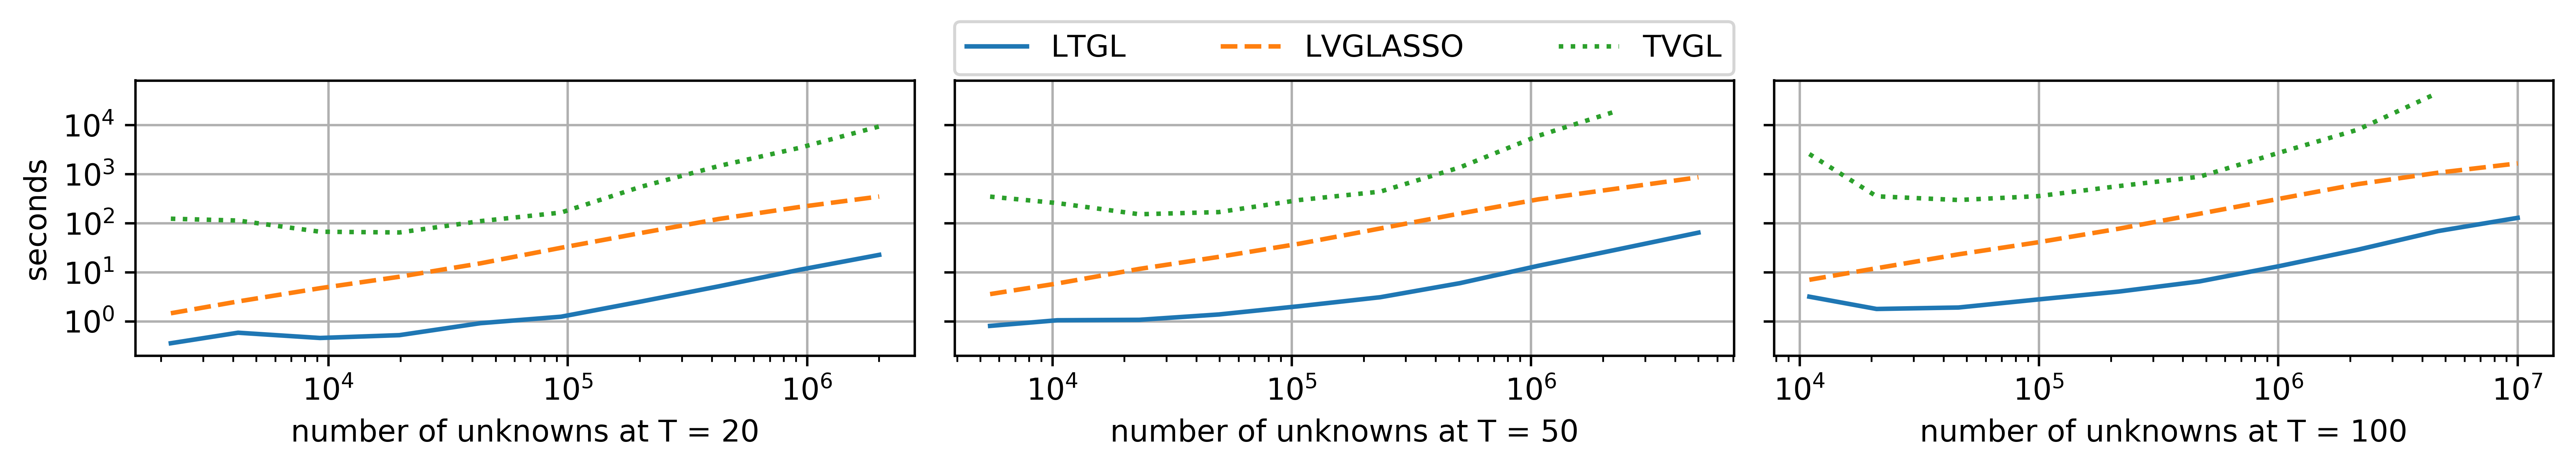

In [70]:
style = ['-', '--', ':']

f, ax = plt.subplots(1, len(n_times), sharey=True, figsize=(12,2), dpi=600)

ax[0].set_ylabel("seconds")
# ax[0].set_ylim([.1,None])
for i, t in enumerate(n_times):
    for j, m in enumerate([m for m in methods if m != 'GL']):
        if m == 'GL':
            continue
        ax[i].plot(n_dims * (n_dims + 1) * t, df.loc[idx[m, t], idx['time',:]].values, ls=style[j], label=m)

    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r"number of unknowns at T = %d" % t)
    ax[i].grid('on')
#     ax[i].set_title("n_times: %d" % t)
    # plt.xticks(range(4), ours.n_dim_obs)
ax[0].set_yticks([1, 10, 1e2, 1e3, 1e4])
lgd = ax[1].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
f.tight_layout()

In [71]:
f.savefig("scalability.pdf", dpi=600, transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')